## Assignment arrhythmia classification

In [1]:
# Run this to use from colab environment
!git clone https://github.com/BrianvanWinden/TM10007_Group_13.git
!unzip "/content/TM10007_Group_13/ecg/ecg_data.zip"
import pandas as pd 

data = pd.read_csv("ecg_data.csv") 

# print(data.head())

Cloning into 'TM10007_Group_13'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 84 (delta 37), reused 47 (delta 14), pack-reused 0
Unpacking objects: 100% (84/84), done.
Archive:  /content/TM10007_Group_13/ecg/ecg_data.zip
  inflating: ecg_data.csv            


# Importing functions

In [55]:
# General packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import datasets as ds
from scipy.stats import randint
from zipfile import ZipFile
from scipy import stats


# Classifiers and kernels
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import PCA
from sklearn import preprocessing, metrics
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics.pairwise import rbf_kernel, sigmoid_kernel
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, roc_auc_score

# Regularization
from sklearn.linear_model import Lasso, RidgeClassifier
from sklearn.feature_selection import SelectFromModel

# Model selection
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, learning_curve, ShuffleSplit, StratifiedKFold

from sklearn.pipeline import Pipeline

from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Sampling
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours



def evaluation(y_val, y_pred, title = 'Confusion Matrix'):
    cm = confusion_matrix(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    # print('Recall: ', recall)
    # print('Accuracy: ', accuracy)
    # print('Precision: ', precision)
    # print('F1: ', f1)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws=    {'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)


# Taking a look at the data

In [4]:
# Samples and features
print(f'The number of samples: {len(data.index)}')
print(f'The number of features: {len(data.columns)}')
healthy_patients = (list(data['label'] == 0)).count(True)
print(f'The number of healthy patients: {healthy_patients}') 
sick_patients = (list(data['label'] == 1)).count(True)
print(f'The number of sick patients: {sick_patients}')
percentage_sick=sick_patients/(sick_patients+healthy_patients)
print(f'Percentage of sick patients: {round(percentage_sick,2)*100}%')

# Outliers
z = np.abs(stats.zscore(data))
x = np.where(z>3)
print(f'Number of features where the Z score is larger {len(x[1])}')

# Missing values
missing_values = data.isna().sum()
number_missing_values = missing_values.astype(bool).sum(axis=0)
print(f'Number of missig data points:{number_missing_values}')

# Data
data_points= data.drop(['label'], axis=1).to_numpy()
data_labels= data['label'].to_numpy()




The number of samples: 827
The number of features: 9002
The number of healthy patients: 681
The number of sick patients: 146
Percentage of sick patients: 18.0%
Number of features where the Z score is larger 57812
Number of missig data points:0


# Preprocessing and classifier validation

In [34]:
# Splitting data  
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

x_train_val, x_test, y_train_val, y_test = train_test_split(data_points, data_labels, test_size=0.2, stratify=data_labels)

cv_outer = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
outer_results = list()
all_scores = list()
models = list()

for train_ix, val_ix in cv_outer.split(x_train_val,y_train_val):
  # split data
  X_train, X_val = x_train_val[train_ix, :], x_train_val[val_ix, :]
  y_train, y_val = y_train_val[train_ix], y_train_val[val_ix]

  #Resampling
  # combines SMOTE over and edited nearest neighbour undersampling
  # edited nearest neighbours kan van beide groepen weghalen, met sampling_strategy='majority' alleen van grote groep
  # the authors comment that ENN is more aggressive at downsampling the majority class than Tomek Links, providing more in-depth cleaning. They apply the method, removing examples from both the majority and minority classes.
  #A Study of the Behavior of Several Methods for Balancing Machine Learning Training Data, 2004.
  resample = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
  X_resampled, y_resampled = resample.fit_resample(X_train, y_train)

  #Scaling
  scaler = preprocessing.RobustScaler()
  scaler.fit(X_resampled)
  x_train_scaled = scaler.transform(X_resampled)
  x_val_scaled = scaler.transform(X_val)

  #PCA
  pca = PCA(n_components=0.99)
  pca = pca.fit(x_train_scaled)
  x_train_trans = pca.transform(x_train_scaled)
  x_val_trans = pca.transform(x_val_scaled)

  cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
  model_params = {'svm': 
                  {'model': SVC(gamma='scale', class_weight='balanced'),
                    'params': {'C': [0.1, 1, 10],
                                'kernel': ['rbf', 'linear']
                               }
                   },
                  'linsvc': 
                  {'model': LinearSVC(class_weight='balanced', dual=True),
                   'params':{'C': [0.1, 1, 10]
                             }
                  }
                }
  for model_name, mp in model_params.items():
    search = GridSearchCV(mp['model'], mp['params'], cv = cv_inner, scoring = 'roc_auc', return_train_score=True)
    result = search.fit(x_train_trans, y_resampled)
    best_model = result.best_estimator_
    models.append(best_model)
    yhat = best_model.predict(x_val_trans)
    auc_score_val = roc_auc_score(y_val, yhat)
    outer_results.append(auc_score_val)
    all_scores.append(result.best_score_)
    print(f'auc: {auc_score_val}, result.best_score_:{result.best_score_}, best parameters:{result.best_params_}')



auc: 0.5287878787878787, result.best_score_:0.9863206765047255, best parameters:{'C': 10, 'kernel': 'rbf'}
auc: 0.546969696969697, result.best_score_:0.984358591720555, best parameters:{'C': 10}
auc: 0.5454545454545454, result.best_score_:0.9826315936913467, best parameters:{'C': 10, 'kernel': 'rbf'}
auc: 0.49999999999999994, result.best_score_:0.9826876208084713, best parameters:{'C': 10}
auc: 0.6818181818181817, result.best_score_:0.9815531760850513, best parameters:{'C': 10, 'kernel': 'rbf'}
auc: 0.6818181818181819, result.best_score_:0.9668461854378099, best parameters:{'C': 10}
auc: 0.6454545454545455, result.best_score_:0.9931385211494996, best parameters:{'C': 10, 'kernel': 'rbf'}
auc: 0.6636363636363637, result.best_score_:0.9811376601011731, best parameters:{'C': 1}
auc: 0.6759259259259258, result.best_score_:0.9935438546405296, best parameters:{'C': 10, 'kernel': 'rbf'}
auc: 0.6851851851851852, result.best_score_:0.9711184074932867, best parameters:{'C': 10}
auc: 0.625, resul

TypeError: ignored

# Best classifier for test set

                                               Models  Auc score  Best score
18  SVC(C=10, break_ties=False, cache_size=200, cl...   0.819444    0.972518
16  SVC(C=10, break_ties=False, cache_size=200, cl...   0.800926    0.939158
19  LinearSVC(C=1, class_weight='balanced', dual=T...   0.722222    0.975452
9   LinearSVC(C=10, class_weight='balanced', dual=...   0.685185    0.971118
5   LinearSVC(C=10, class_weight='balanced', dual=...   0.681818    0.966846
4   SVC(C=10, break_ties=False, cache_size=200, cl...   0.681818    0.981553
8   SVC(C=10, break_ties=False, cache_size=200, cl...   0.675926    0.993544
7   LinearSVC(C=1, class_weight='balanced', dual=T...   0.663636    0.981138
17  LinearSVC(C=10, class_weight='balanced', dual=...   0.662037    0.889653
13  LinearSVC(C=1, class_weight='balanced', dual=T...   0.652778    0.960386
6   SVC(C=10, break_ties=False, cache_size=200, cl...   0.645455    0.993139
11  LinearSVC(C=10, class_weight='balanced', dual=...   0.643519    0.977363

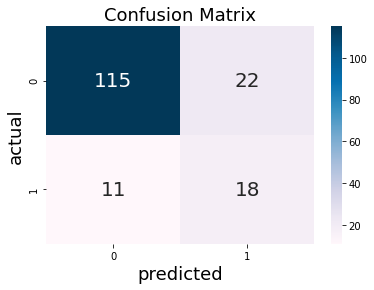

In [62]:
models_df = pd.DataFrame(models)
outer_results_df = pd.DataFrame(outer_results)
all_scores_df = pd.DataFrame(all_scores)
results = pd.concat([models, outer_results, all_scores], axis=1)
results.columns = ['Models', 'Auc score', 'Best score']
results_sorted = results.sort_values(by=['Auc score'], ascending=False)
print(results_sorted)

best_classifier = results_sorted['Models'].iloc[0]
print(best_classifier)

#Resampling
resample = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
X_resampled, y_resampled = resample.fit_resample(x_train_val, y_train_val)

#Scaling
scaler = preprocessing.RobustScaler()
scaler.fit(X_resampled)
x_train_scaled = scaler.transform(X_resampled)
x_test_scaled = scaler.transform(x_test)

#PCA
pca = PCA(n_components=0.99)
pca = pca.fit(x_train_scaled)
x_train_trans = pca.transform(x_train_scaled)
x_test_trans = pca.transform(x_test_scaled)

# Evaluation classifier
clf = best_classifier.fit(x_train_trans, y_resampled)
y_pred = clf.predict(x_test_trans)
accuracy = metrics.balanced_accuracy_score(y_test, y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)
print('Misclassified: %d / %d' % ((y_test != y_pred).sum(), x_test.shape[0]), str(clf))
evaluation(y_test, y_pred)

print(f'Auc score test data: {auc}')
